# Analyzing molecular trajectories

In [2]:
import warnings
warnings.filterwarnings('ignore')

import os
import json
import zipfile
import pandas as pd
from tqdm.auto import tqdm
from io import TextIOWrapper
from collections import defaultdict

Preparing the records for analysis.

In [3]:
def get_records(path, measure):

    trial_indices = defaultdict(int)
    hit_records_ = []
    records_ = []
    with zipfile.ZipFile(path, 'r') as z:
        for filename in tqdm(z.namelist()):
            if filename.endswith('.json'):
                with z.open(filename) as file:
                    with TextIOWrapper(file, encoding='utf-8') as text_file:
                        try:
                            # Load results
                            result = json.load(text_file)
                            value = result[measure]
                            if value == 1.0: # temperature 0.16 limit 1
                                record_raw = pd.DataFrame(
                                    result['annotations']
                                ).reindex(
                                    columns=[
                                        'SMILES',
                                        'Step Designed',
                                        'Step Made',
                                        'Step Scored',
                                        'Step Tested',
                                        'ABL1 pIC50',
                                        'Log P',
                                        'Log S'
                                    ]
                                )

                                # Process record
                                hit_record = record_raw.iloc[:5]
                                record = record_raw.dropna()

                                # Get measure of interest
                                record[measure] = value
                                hit_record[measure] = value

                                # Increment trial
                                trial_indices[value] += 1
                                record['trial'] = trial_indices[value]
                                hit_record['trial'] = trial_indices[value]

                                # Record list
                                hit_records_.append(hit_record)
                                records_.append(record)
                                result = None
                        except:
                            continue
    return records_, hit_records_

paths = [
     '../../dgym-data/analysis/noise/selection_noise_2024-05-10_23-36-56.zip',
]

measure = 'sigma'
hit_records = []
records = []
for path in paths:
    records_, hit_records_ = get_records(path, measure)
    records.extend(records_)
    hit_records.extend(hit_records_)

df_raw = pd.concat(records)
df_raw_hits = pd.concat(hit_records)
records = None
records = None

  0%|          | 0/500 [00:00<?, ?it/s]

# Score data

### Scoring starting hits

Load oracles.

In [4]:
import os

def get_tcp_objectives():

    dockstring_dir = f'../../dgym-data/dockstring_targets/'
    files = os.listdir(dockstring_dir)
    configs = sorted([f for f in files if 'conf' in f])
    targets = sorted([f for f in files if 'target' in f])

    idx = 0
    with open(dockstring_dir + configs[idx], 'r') as f:
        config_ = f.readlines()
        config_ = [c.replace('\n', '') for c in config_]
        config_ = [c.split(' = ') for c in config_ if c]
        config_ = {c[0]: float(c[1]) for c in config_}

    target = targets[idx]
    name = target.split('_')[0]

    config_.update({
        'size_x': 22.5,
        'size_y': 22.5,
        'size_z': 22.5,
    })

    from dgym.envs.oracle import \
        DockingOracle, CatBoostOracle, RDKitOracle, NoisyOracle

    config = {
        'search_mode': 'detailed',
        'scoring': 'vina',
        'seed': 5,
        **config_
    }

    pIC50_oracle = DockingOracle(
        f'{name} pIC50',
        receptor_path=f'../../dgym-data//dockstring_targets/{name}_target.pdbqt',
        config=config
    )
    log_P_oracle = RDKitOracle('Log P', descriptor='MolLogP')
    log_S_oracle = CatBoostOracle(
        'Log S', path='../dgym/envs/models/aqsolcb.model')
    
    return pIC50_oracle, log_P_oracle, log_S_oracle

Score hits.

In [5]:
import dgym as dg

hits = dg.collection.MoleculeCollection(
    [dg.molecule.Molecule(s) for s in df_raw_hits.SMILES]
)

pIC50_oracle, log_P_oracle, log_S_oracle = get_tcp_objectives()
df_raw_hits['ABL1 pIC50'] = pIC50_oracle(hits, batch_size=40)
df_raw_hits['Log P'] = log_P_oracle(hits, batch_size=40)
df_raw_hits['Log S'] = log_S_oracle(hits, batch_size=40)
df_raw_hits = df_raw_hits.fillna(0.0)

[]
unidock --receptor ../../dgym-data//dockstring_targets/ABL1_target.pdbqt --ligand_index /tmp/tmp_kmubmh6/ligands.txt --dir /tmp/tmp_kmubmh6 --search_mode detailed --scoring vina --seed 5 --center_x 15.851 --center_y 14.647 --center_z 3.904 --size_x 22.5 --size_y 22.5 --size_z 22.5
CompletedProcess(args='unidock --receptor ../../dgym-data//dockstring_targets/ABL1_target.pdbqt --ligand_index /tmp/tmp_kmubmh6/ligands.txt --dir /tmp/tmp_kmubmh6 --search_mode detailed --scoring vina --seed 5 --center_x 15.851 --center_y 14.647 --center_z 3.904 --size_x 22.5 --size_y 22.5 --size_z 22.5', returncode=0, stdout='Uni-Dock v1.1.0\n\nIf you used Uni-Dock in your work, please cite:               \n \nYu, Y., Cai, C., Wang, J., Bo, Z., Zhu, Z., & Zheng, H. (2023). \nUni-Dock: GPU-Accelerated Docking Enables Ultralarge Virtual Screening. \nJournal of Chemical Theory and Computation.                    \nhttps://doi.org/10.1021/acs.jctc.2c01145                       \n\nTang, S., Chen, R., Lin, M.,


KeyboardInterrupt



Write to disk.

In [ ]:
pd.concat([df_raw_hits, df_raw]).to_csv('../../dgym-data/analysis/novartis/trajectories_2.csv')

Load from disk.

`Temperature = 0.16`

In [6]:
import pandas as pd
df_raw_complete = pd.read_csv('../../dgym-data/analysis/novartis/trajectories_2.csv', index_col=0).query('sigma == 1.0')

Assign outcomes.

In [7]:
from dgym.envs.utility import MultipleUtilityFunction, ClassicUtilityFunction

# create evaluators
docking_utility_function = ClassicUtilityFunction(
    ideal=(9, 13),
    acceptable=(8, 13)
)

log_P_utility_function = ClassicUtilityFunction(
    ideal=(-0.5, 3.5),
    acceptable=(-0.5, 3.5)
)

log_S_utility_function = ClassicUtilityFunction(
    ideal=(-4, 1),
    acceptable=(-4, 1)
)

composite_utility_function = MultipleUtilityFunction([
    docking_utility_function, log_P_utility_function, log_S_utility_function])

In [8]:
from tqdm.auto import tqdm

records = []
for trial, data in tqdm(df_raw_complete.groupby('trial')):
    utility = composite_utility_function(
        data.reindex(columns=['ABL1 pIC50', 'Log P', 'Log S']).values,
        precompute=True,
        method='average'
    )
    try:
        cost = utility.index(1.0)
        outcome = 1
    except:
        cost = len(utility)
        outcome = 0

    data['utility'] = utility
    data['outcome'] = outcome
    records.append(data)
    
df = pd.concat(records).query('outcome == 1')

  0%|          | 0/100 [00:00<?, ?it/s]

Featurize.

In [9]:
from tqdm.auto import tqdm
from scikit_mol.conversions import SmilesToMolTransformer
from scikit_mol.descriptors import MolecularDescriptorTransformer

smiles_to_mol = SmilesToMolTransformer(parallel=True)
desc_list = [
    'HeavyAtomCount',
    'FractionCSP3',
    'NumRotatableBonds',
    'TPSA',
    'RingCount',
    'NumAliphaticRings',
    'NumAromaticRings',
    'NOCount',
    'NHOHCount',
    'HeavyAtomMolWt',
    'ExactMolWt',
    'NumHAcceptors',
    'NumHDonors',
    'qed'
]
featurizer = MolecularDescriptorTransformer(
    desc_list, parallel=True)

trial_data = []
for trial, data in tqdm(df.groupby('trial')):
    rd_mols = smiles_to_mol.transform(data['SMILES'].values)
    X = featurizer.transform(rd_mols)
    
    for (label, features) in zip(desc_list, X.T):
        data[label] = features
    
    # Convert step made to Progress of Series as in Novartis paper.
    data['Progress Raw'] = data['Step Made'] / data['Step Made'].max() * 100

    trial_data.append(data)
    
mol_properties = pd.concat(trial_data)

  0%|          | 0/99 [00:00<?, ?it/s]

Adding features based on ratios and binning.

In [10]:
mol_properties['LE'] = 1.4 * mol_properties['ABL1 pIC50'] / mol_properties['HeavyAtomCount']
mol_properties['LipE'] = mol_properties['ABL1 pIC50'] - mol_properties['Log P']

for descriptor in desc_list[2:]:
    mol_properties[f'{descriptor}/1000 atoms'] = \
        mol_properties[descriptor] / mol_properties['HeavyAtomCount'] * 1000
    
num_bins = 100
mol_properties['Progress (%)'] = pd.cut(
    mol_properties['Progress Raw'], num_bins, labels=range(num_bins))

Plotting

/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0.5, 1.0, 'Max utility by progress (%)')

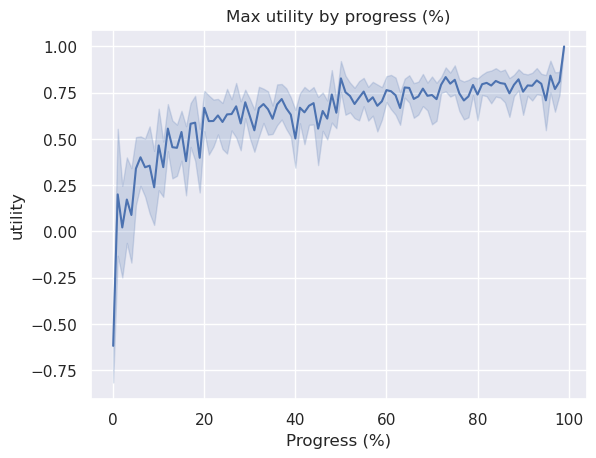

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.lineplot(
    data=(
        mol_properties
        .groupby(['trial', 'Progress (%)'])
        .agg({'utility': 'max'})
        .reset_index()
    ),
    x='Progress (%)',
    y='utility',
    errorbar=('ci', 99),
)

plt.title('Max utility by progress (%)')

/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0.5, 1.0, 'Evolution of chemical properties over repeated trials')

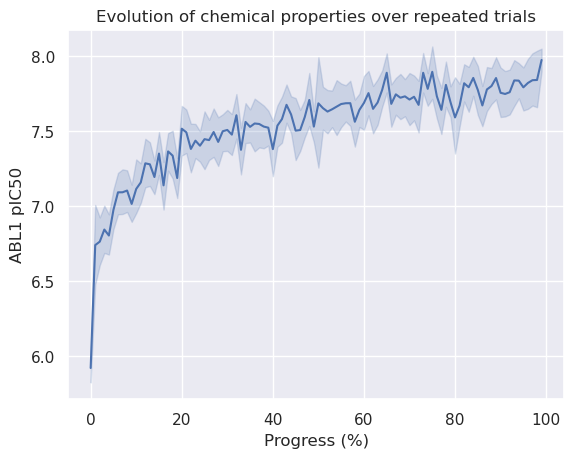

In [13]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
sns.lineplot(
    data=mol_properties,
    x='Progress (%)',
    y='ABL1 pIC50',
    errorbar=('ci', 99),
    # estimator=lambda x: np.quantile(x, 0.95),
)

plt.title('Evolution of chemical properties over repeated trials')

## Using faceting

In [14]:
columns = [
    'SMILES', 'Progress (%)',
    'ABL1 pIC50', 'Log P', 'Log S',
    # Lipinski
    'ExactMolWt', 'NumHAcceptors', 'NumHDonors', 'Log P',
    # Veber
    'NumRotatableBonds', 'TPSA',
    # Rule of three
    'HeavyAtomCount',
    # Composite measures
    'qed', 'LE', 'LipE',
    # Miscellaneous
    'FractionCSP3', 'RingCount', 'NumAliphaticRings', 'NumAromaticRings', 'NOCount', 'NHOHCount',
]

long_df = pd.melt(
    mol_properties.reindex(columns=columns),
    id_vars=['SMILES', 'Progress (%)'],
    var_name='Property',
    value_name='Value'
)

/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and 

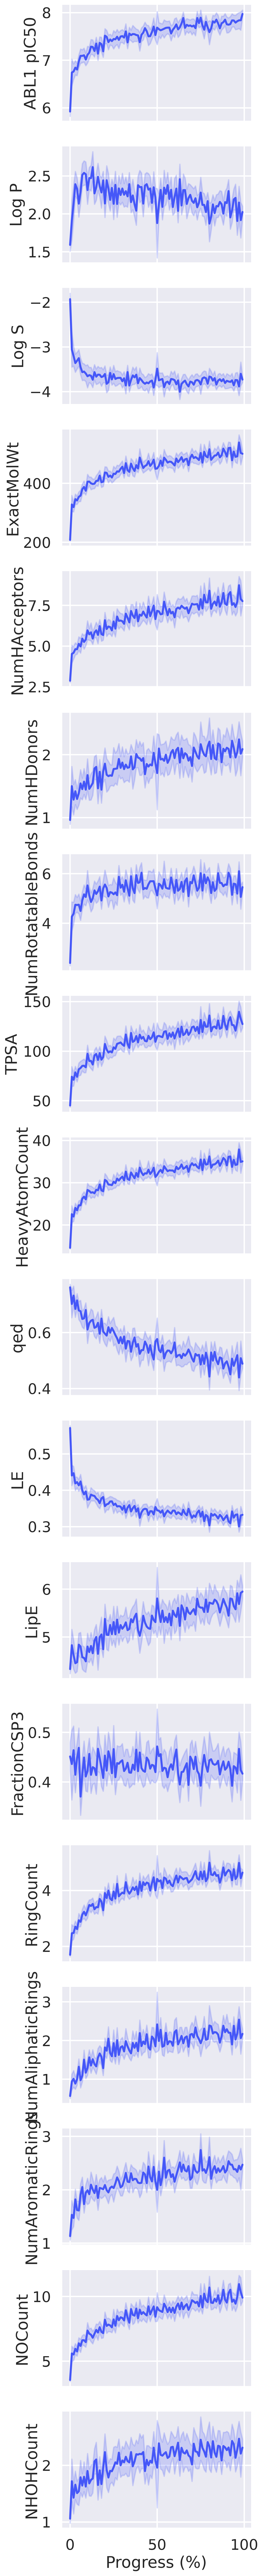

In [29]:
sns.set('poster')

g = sns.FacetGrid(long_df, col='Property', col_wrap=1, sharey=False, aspect=2)
g.map_dataframe(sns.lineplot, x='Progress (%)', y='Value', color='#4557F8', errorbar=('ci', 99))

g.set_titles("")
g.set_axis_labels("Progress (%)", "")
g.set(xticks=[0, 50, 100])

# Set the property name as y-axis label
for ax, title in zip(g.axes.flat, g.col_names):
    ax.set_ylabel(title)
    
g.fig.tight_layout()
g.fig.set_dpi(300)

# Analyze best molecule affinity

In [15]:
time = 'Progress (%)'
measure = 'ABL1 pIC50'

max_step = int(mol_properties[time].max())
repeats = []
for idx, row in tqdm(mol_properties[[time, measure]].iterrows()):
    step_made = int(row[time])
    for jdx in range(step_made, max_step+1):
        row_repeat = dict(row)
        if time == 'Progress (%)' and jdx == 99:
            jdx = 100
        row_repeat[time] = jdx
        repeats.append(row_repeat)

df = pd.DataFrame(repeats)

0it [00:00, ?it/s]

/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0.5, 1.0, 'Distribution of ligand potencies across rounds')

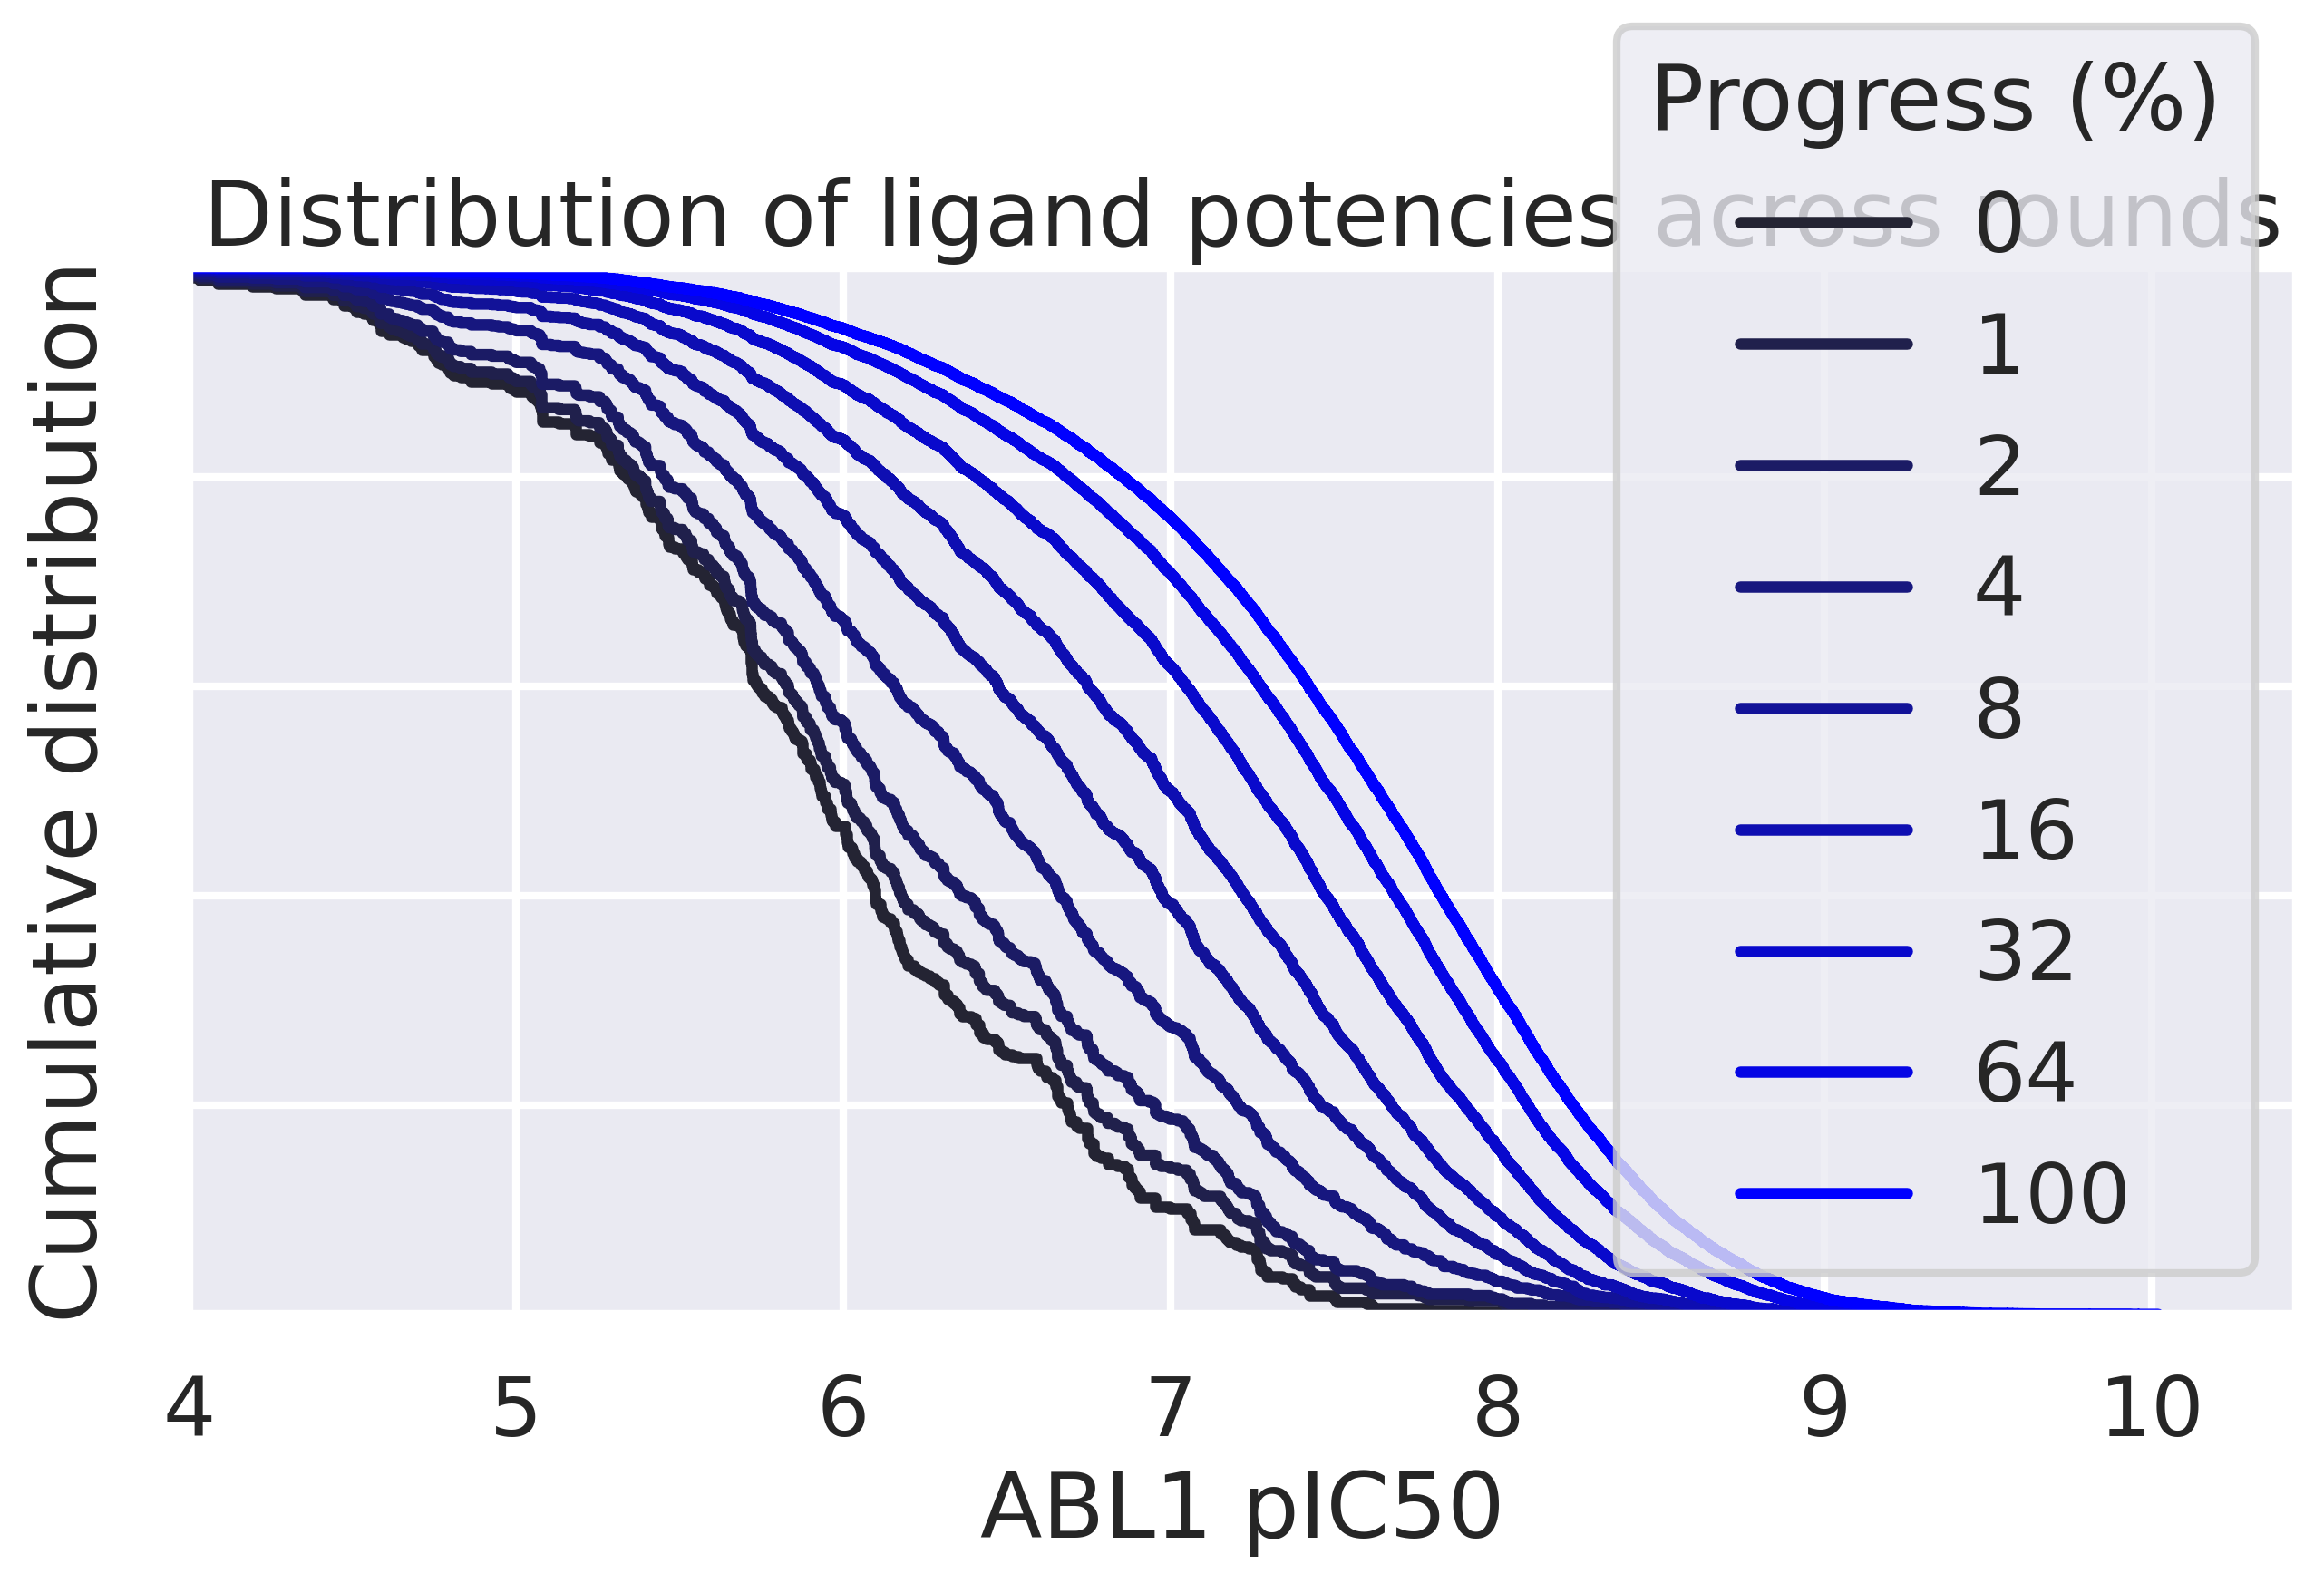

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set('poster')
plt.figure(figsize=(10, 5), dpi=300)

legend = [0, 1, 2, 4, 8, 16, 32, 64, max(df[time])]
g = sns.ecdfplot(
    (
        df
        .query(f'`{time}` in {legend}')
    ),
    x=measure,
    hue=time,
    palette=sns.color_palette('dark:blue_r', len(legend)),
    complementary=True,
    hue_order=reversed(legend)
)

# Reorder legend handles and labels according to the new_order
handles = g.legend_.legend_handles
labels = [int(text.get_text()) for text in g.legend_.texts]
label_to_handle = dict(zip(labels, handles))
ordered_handles = [handles[labels.index(label)] for label in legend]

# Remove old legend and create new one
g.legend_.remove()
g.legend(title=time, labels=legend, handles=ordered_handles, loc='best')
g.set(yticklabels=[])

# plt.xlim(-7.5, 1.5)
plt.xlim(4)
plt.xlabel(measure)
plt.ylabel('Cumulative distribution')
plt.title('Distribution of ligand potencies across rounds')